# Evaluation of multi-omics GRN inference methods
## Preprocessing multi-omics data
### by Jalil Nourisa

# Imports 

In [1]:
import os
import gzip
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix


import scanpy as sc
import matplotlib.pyplot as plt
import tqdm
import scipy
import seaborn as sns
import json
import anndata as ad
import warnings
# import decoupler as dc

# from venn import venn 

import matplotlib
matplotlib.rc('font', family='serif')
matplotlib.rc('text', usetex='false')
matplotlib.rcParams.update({'font.size': 10})

input_dir = '../../task_grn_inference/resources/grn-benchmark/'
work_dir = '../output'

T_cells = ['T regulatory cells', 'T cells CD8+', 'T cells CD4+']
def func_leiden(adata):
    adata.layers['counts'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    sc.tl.pca(adata, n_comps=50, use_highly_variable=True)
    sc.pp.neighbors(adata, n_pcs=30)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
def plot_umap(adata_o, color='leiden', ax=None, groups=None):
    adata = adata_o.copy()
    if groups is not None:
        adata.obs[color] = adata.obs[color].astype(str)
        mask = adata.obs[color].isin(groups)
        print(mask.sum())
        adata.obs.loc[~mask, color] = 'background'
    #     adata.obs['color'] = adata.obs['color'].astype(str).astype(categorical)
        
    x_data = adata.obsm['X_umap'][:,0]
    y_data = adata.obsm['X_umap'][:,1]
    xlim = [min(x_data)+.1*min(x_data), max(x_data)+.1*max(x_data)]
    ylim = [min(y_data)+.1*min(y_data), max(y_data)+.1*max(y_data)]
    if isinstance(adata.obs[color].iloc[0], (int, float)):
        # Continuous variable
        scatter = ax.scatter(x_data, y_data, c=adata.obs[color], cmap='viridis', alpha=0.3, s=1)
        plt.colorbar(scatter, ax=ax)
    else:
        unique_colors = adata.obs[color].unique()
        num_colors = len(unique_colors)
        if num_colors > 10:
            cmap = plt.get_cmap('tab20')  # Use a color map with more distinct colors
            color_list = cmap(np.linspace(0, 1, num_colors))
            color_list = [list(color_list[i]) for i in range(num_colors)]  # Convert each color to list format

        else:
            color_list = None  # Use default color map if fewer than 10 colors
            
        for i, c in enumerate(unique_colors):
            mask = adata.obs[color]==c
            if c == 'background':
                ax.scatter(x_data[mask], y_data[mask], s=.5, label=c, color='lightgrey', alpha=.01)
            else:
                ax.scatter(x_data[mask], y_data[mask], s=1, label=c, color=color_list[i] if color_list else None, alpha=.3)
            if color == 'leiden':
                avg_x = np.mean(x_data[mask])
                avg_y = np.mean(y_data[mask])
                ax.annotate(c, (avg_x, avg_y),ha='center', fontsize=15)

    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks([])
    ax.set_yticks([])

    if color!='leiden':
        legend = ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
        # legend = ax.legend()
        for handle in legend.legendHandles:
            handle.set_sizes([50])
    ax.set_title(color)
def plot_umap_group(adata, colors):
    n = len(colors)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 4))
    for ii, color in enumerate(colors):
        plot_umap(adata, color=color, ax=axes[ii])
    plt.tight_layout()
    return fig

# scRNA-seq
We use provided normalized values as X and store the counts in the layers.

## QS

In [29]:
multiomics_rna = ad.read(f'{input_dir}/multiomics_rna.h5ad')
multiomics_rna

AnnData object with n_obs × n_vars = 25551 × 22787
    obs: 'cell_type', 'donor_id'
    var: 'gene_ids', 'interval'

In [4]:
import sctk
sctk.calculate_qc(multiomics_rna, flags={"mito": r"^MT-", "ribo": r"^RP[LS]"})
# sctk.calculate_qc(multiomics_rna)
sctk.cellwise_qc(multiomics_rna)

/root/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


n_counts: [1000.0000463230983, 19978.994140625], 25547/25547 passed
n_genes: [691.1768837674327, 5745.001953125], 25429/25547 passed
percent_mito: [0.0, 15.571746011893392], 25402/25547 passed
percent_ribo: [0.8829415259221228, 16.21716400235061], 25201/25547 passed
25034/25547 pass


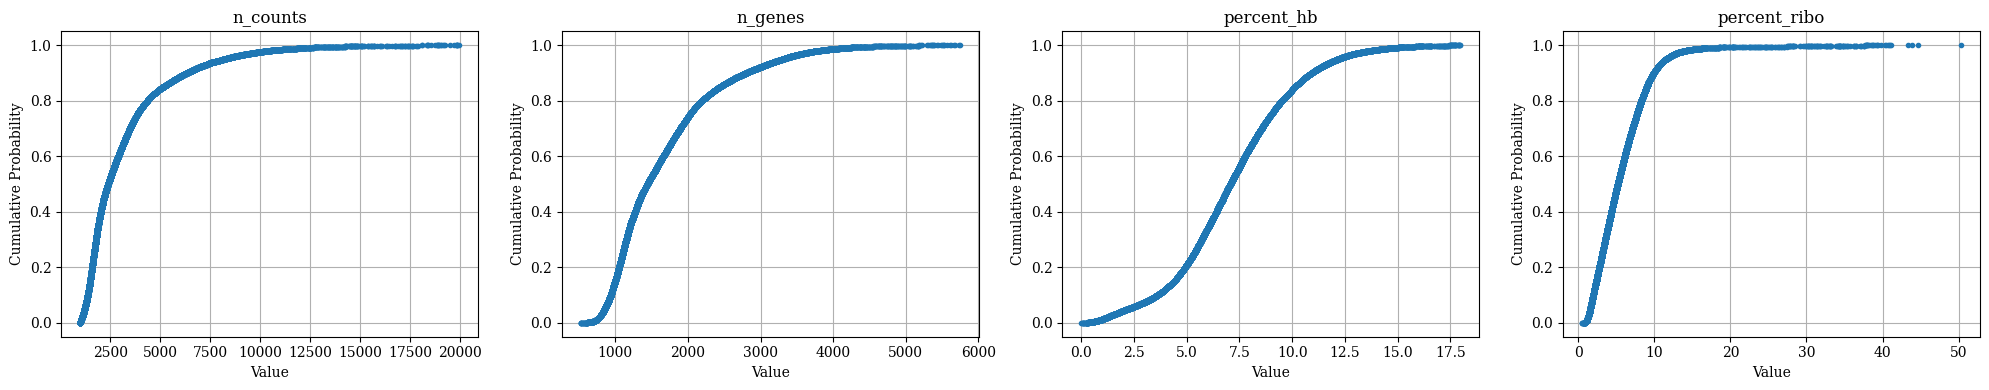

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(20,4))
def plot_CDF(data, title, ax):
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    ax.plot(x, y, marker='.', linestyle='none')
    ax.set_xlabel('Value')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title(title)
    ax.grid(True)

plot_CDF(multiomics_rna.obs.n_counts, 'n_counts', axes[0])
plot_CDF(multiomics_rna.obs.n_genes, 'n_genes', axes[1])
plot_CDF(multiomics_rna.obs.percent_mito, 'percent_hb', axes[2])
plot_CDF(multiomics_rna.obs.percent_ribo, 'percent_ribo', axes[3])
plt.tight_layout()
plt.show()

## UMAP

In [30]:

# sc.pp.normalize_total(multiomics_rna)
# sc.pp.log1p(multiomics_rna)
# sc.pp.scale(multiomics_rna)

sc.pp.highly_variable_genes(multiomics_rna, n_top_genes=2000, flavor='seurat_v3', layer=None)

multiomics_rna_hvg = multiomics_rna[:, multiomics_rna.var.highly_variable]


sc.pp.neighbors(multiomics_rna_hvg)
sc.tl.umap(multiomics_rna_hvg)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [37]:
multiomics_rna_hvg.obs.donor_id = multiomics_rna_hvg.obs.donor_id.map({'donor_0': 'Donor 1', 'donor_1': 'Donor 2', 'donor_2': 'Donor 3'})

../output/preprocess/figs/umap_rna.png


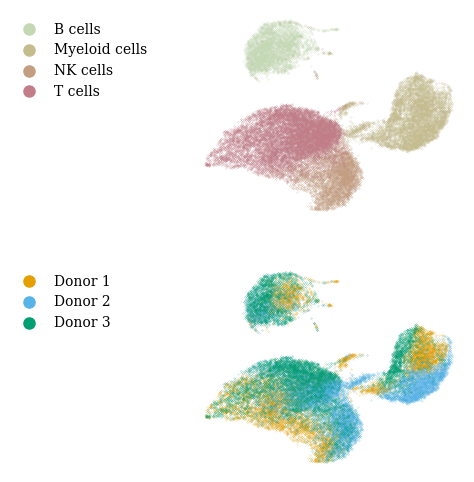

In [41]:
from local_utils import plots 
figsize = (3.5, 6)
fig, axes = plt.subplots(2, 1, figsize=figsize, sharey=False)
bbox_to_anchor = (-.7, 1)
s = .02
ax = axes[0]
plots.plot_umap(multiomics_rna_hvg, color='cell_type', palette=plots.colors_cell_type, ax=ax, 
                bbox_to_anchor=bbox_to_anchor, s=s)
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.get_legend().get_title().set_fontweight('bold')

ax = axes[1]
plots.plot_umap(multiomics_rna_hvg, color='donor_id', palette=plots.colors_blind, 
                ax=ax, bbox_to_anchor=bbox_to_anchor, s=s)
ax.get_legend().get_title().set_fontweight('bold')
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
print(f'{work_dir}/preprocess/figs/umap_rna.png')
fig.savefig(f'{work_dir}/preprocess/figs/umap_rna.png', dpi=200, transparent=True, bbox_inches='tight')

# scATAC-seq

## Formatize the data

## UMAP plot using scATAC-seq


In [4]:
adata_atac = ad.read_h5ad(f'{input_dir}/multiomics_atac.h5ad')

In [5]:
adata_atac.layers['counts'] = adata_atac.X.copy()

In [6]:
# import warnings
warnings.simplefilter("ignore")
with warnings.catch_warnings():
    sc.pp.normalize_total(adata_atac)
    sc.pp.log1p(adata_atac)
    sc.pp.highly_variable_genes(adata_atac, n_top_genes=2000)
    sc.tl.pca(adata_atac, svd_solver='arpack', use_highly_variable=True)
    sc.pp.neighbors(adata_atac, n_neighbors=10, n_pcs=50)
    sc.tl.umap(adata_atac)
adata_atac

AnnData object with n_obs × n_vars = 25551 × 135418
    obs: 'cell_type', 'donor_id'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

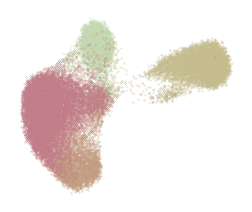

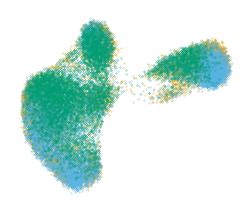

In [42]:
from local_utils import plots 
figsize = (3, 2.5)
fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=False)
bbox_to_anchor = (-.5, 1)
s = .05
plots.plot_umap(adata_atac, color='cell_type', palette=plots.colors_cell_type, ax=ax, 
                bbox_to_anchor=bbox_to_anchor, s=s, legend=False)
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')

fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=False)
plots.plot_umap(adata_atac, color='donor_id', palette=plots.colors_blind, 
                ax=ax, bbox_to_anchor=bbox_to_anchor, s=s, legend=False)
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')

fig.savefig(f'{work_dir}/preprocess/figs/umap_atac.png', dpi=300, transparent=True)